In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import glob
import os,sys
import csv
import tqdm
import itertools
import pandas as pd
%matplotlib notebook
from scipy import special
from scipy import optimize
from scipy.optimize import curve_fit as scipy
import scipy.integrate as integrate
import scipy.special as special
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.special import gamma, factorial
import mpmath
from mpmath import *
import cmath
from scipy.special import gamma
# Needed for math
import numpy as np
import scipy
import scipy.stats
import os
# Needed for plotting
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

# Set some nice plotting defaults
matplotlib.rcParams["figure.figsize"] = (7, 5)
matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["font.size"] = 18
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.serif"] = [
    "Computer Modern",
    "Latin Modern Roman",
    "Bitstream Vera Serif",
]
matplotlib.rcParams["font.sans-serif"] = [
    "Computer Modern Sans serif",
    "Helvetica",
    "Avant Garde",
]
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["axes.linewidth"] = 1.0
matplotlib.rcParams["font.weight"] = "bold"
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    "color", ["#29A2C6", "#FF6D31", "#73B66B", "#EF597B", "#333333", "#FFCB18"]
)
matplotlib.rcParams["axes.grid"] = False
matplotlib.rcParams["patch.linewidth"] = 2
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["xtick.labelsize"] = "medium"
matplotlib.rcParams["ytick.labelsize"] = "medium"
matplotlib.rcParams["xtick.minor.visible"] = True
matplotlib.rcParams["ytick.minor.visible"] = True
matplotlib.rcParams["xtick.major.size"] = 8
matplotlib.rcParams["xtick.minor.size"] = 4
matplotlib.rcParams["ytick.major.size"] = 8
matplotlib.rcParams["ytick.minor.size"] = 4
matplotlib.rcParams["xtick.major.width"] = 1.2
matplotlib.rcParams["xtick.minor.width"] = 1.2
matplotlib.rcParams["ytick.major.width"] = 1.2
matplotlib.rcParams["ytick.minor.width"] = 1.2
matplotlib.rcParams["legend.frameon"] = False
matplotlib.rcParams["legend.fontsize"] = 12

In [80]:
def filereader(file):
    data = pd.read_csv('%s' % file, sep = "  ", header = None)
    df = pd.DataFrame(data)
    df.columns = ['energy','event']
    df_x = np.array(df['event'])
    df_e = np.array(df['energy'])
    split_line = file.split('_w')
    w = split_line[1]
    return df_e, df_x, w
    

In [81]:
def xs_per_mode(mode, true_energy):
    mode, true_energy = mode, true_energy
    
    path = '/Users/darcynewmark/Desktop/LANL/Post-Bacc/Theory/'
    os.chdir(path)
    for file in sorted(os.listdir(path)):
        if '_nu_w' in file:
            df_e, df_x, w = filereader(file)
            
            if int(w) == mode: ## if we're in the right mode
                for i in range(len(df_e)): ## let's loop over energy
                    if float(df_e[i]) == true_energy: #until we find desired true energy
                        return df_x[i], df_x ## returning single xs value at given true_energy 
                                                ##and array of xs for mode 
                

In [87]:
## this is a function to make unweighted smearing matrix but not necessary since it doesn't change
## I calculate unweighted smearing matrix once below

# def entire_smear_unweighted():
    
#     empty = np.zeros((1, 200,200)) 

#     path_smear = '/Users/darcynewmark/theory/charged_current/Jan2022/flat_smearing/test'

#     os.chdir(path_smear)
#     for file in sorted(os.listdir(path_smear)):

#         if 'smear_' in file:
#             filename = str(file)

#             w_of_file = filename.split('flat_w')
#             gamma_energy = (w_of_file[1].split('.dat'))[0]
#             gamma_index = float(gamma_energy)-1

#             smear = pd.read_csv('%s' % file , sep = ",", header = None) 
#             sm = pd.DataFrame(smear)
#             sm[len(sm.columns)-1] = sm[len(sm.columns)-1].map(lambda x: (x.replace('{', '').replace('}:', '').replace('};', '')if type(x) == str else x ))
#             sm = sm.iloc[:200, 2:]
#             sm = sm.values.astype(float)

#             sm = sm.reshape((1, sm.shape[0], sm.shape[1]))
#             running_tally = np.concatenate([sm, empty])
#             empty = running_tally

#     m_3d = running_tally[:-1]
#     m_3d = np.swapaxes(m_3d, 1, 2)
    
#     return m_3d


In [82]:
## make unweighted smearing matrix 

empty = np.zeros((1, 200,200)) 

path_smear = '/Users/darcynewmark/theory/charged_current/Jan2022/flat_smearing/test'

os.chdir(path_smear)
for file in sorted(os.listdir(path_smear)):

    if 'smear_' in file:
        filename = str(file)

        w_of_file = filename.split('flat_w')
        gamma_energy = (w_of_file[1].split('.dat'))[0]
        gamma_index = float(gamma_energy)-1

        smear = pd.read_csv('%s' % file , sep = ",", header = None) 
        sm = pd.DataFrame(smear)
        sm[len(sm.columns)-1] = sm[len(sm.columns)-1].map(lambda x: (x.replace('{', '').replace('}:', '').replace('};', '')if type(x) == str else x ))
        sm = sm.iloc[:200, 2:]
        sm = sm.values.astype(float)

        sm = sm.reshape((1, sm.shape[0], sm.shape[1]))
        running_tally = np.concatenate([sm, empty])
        empty = running_tally

m_3d = running_tally[:-1]
m_3d = np.swapaxes(m_3d, 1, 2)
 

In [88]:
def smear_factor(mode, reco_energy):
    # want to return smear = smearing matrix elements at reco energy summed over true energy for given mode
    
    mode, reco_energy_of_interest = mode, reco_energy
    
    true_energy = np.linspace(0.5, 100, 200)
    reco_energy = np.linspace(0.5, 100, 200)
    
    M = np.zeros((200, 200))
    df_x = np.asarray(xs_per_mode(mode, 10.0)[1]) ##true energy doesnt matter since returning array of xs
#     m_3d = entire_smear_unweighted()
    
    for i in range(len(true_energy)):
        for j in range(len(reco_energy)):
            numerator = (df_x[i]*m_3d[:, i , j]).sum()
            denominator = (df_x[i].sum())

            if numerator == 0:
                M[i, j] = 0.0

            else:
                M[i, j] = numerator/denominator
                
    ### M is now smearing matrix for specified mode, still need to sum over true energy at specified reco energy
    smear = M[:, int(reco_energy_of_interest)].sum()

    return smear


    

In [106]:
### function to calculate covariance between bin 0 and bin 1
def cov_bin0_to_bin1(true_energy0, reco_energy0,true_energy1, reco_energy1 ):
    true_energy0, reco_energy0,true_energy1, reco_energy1 = true_energy0, reco_energy0,true_energy1, reco_energy1 
    
    w = np.linspace(1, 14, 14)
    sub_cov = 0
    total_cov =  []

    
#     for i in range(14):  ## looping over 14 modes
#         sub_cov = xs_per_mode(i+1, true_energy0)[0] * xs_per_mode(i+1, true_energy1)[0] * (0.15)**2 * smear_factor(i+1, reco_energy0) * smear_factor(i+1, reco_energy1)
#         total_cov += sub_cov

    for mode in w:
        sub_cov = xs_per_mode(mode, true_energy0)[0] * xs_per_mode(mode, true_energy1)[0] * (0.15)**2 * smear_factor(mode, reco_energy0) * smear_factor(mode, reco_energy1)
        total_cov.append(sub_cov)
        
    return (sum(total_cov))





In [108]:
### function to calculate variance on diagonal
def var_bin0_to_bin1(true_energy0, reco_energy0,true_energy1, reco_energy1 ):
    true_energy0, reco_energy0,true_energy1, reco_energy1 = true_energy0, reco_energy0,true_energy1, reco_energy1 
    
    sub_var = 0
    total_var =  []
    
#     for i in range(14):  ## looping over 14 modes
#         sub_var = xs_per_mode(i+1, true_energy0)[0] * xs_per_mode(i+1, true_energy1)[0] * ((0.15)**2 +(0.40)**2) * smear_factor(i+1, reco_energy0) * smear_factor(i+1, reco_energy1)
#         total_var += sub_var

    for mode in w:
        sub_var = xs_per_mode(mode, true_energy0)[0] * xs_per_mode(mode, true_energy1)[0] * ((0.15)**2 +(0.40)**2) * smear_factor(mode, reco_energy0) * smear_factor(mode, reco_energy1)
        total_var.append(sub_var)
    
    return (sum(total_var))


In [109]:
print(cov_bin0_to_bin1(5.0 ,5.0 ,5.5 ,5.5))
print(var_bin0_to_bin1(5.0 ,5.0 ,5.0 ,5.0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


1.3154362171505527e-07
3.5565497722959393e-07


[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19.]


In [126]:
### let's now calculate and plot the covariance matrix!

# reco_energy = np.linspace(0.5, 100, 200)
# true_energy = np.linspace(0.5, 100, 200)

reco_energy = np.linspace(1, 19, 10)
true_energy = np.linspace(1, 19, 10)


C_3d = np.zeros((len(reco_energy), len(reco_energy), len(true_energy))) 
C = np.zeros((len(reco_energy), len(reco_energy))) ## cov is reco vs reco

# for i in range(len(reco_energy)):
#     for j in range(len(reco_energy)):
#         for k in range(len(true_energy)):
            
#             if i == j: ## the variance
#                 var = var_bin0_to_bin1( true_energy[k], reco_energy[i], true_energy[k], reco_energy[j])
#                 C_3d[i, j, k] = var

#             cov = cov_bin0_to_bin1( true_energy[k], reco_energy[i], true_energy[k], reco_energy[j])
#             C_3d[i, j, k] = cov
            
            
for alpha, beta, gamma in tqdm.tqdm(itertools.product(reco_energy, reco_energy, true_energy), total = 10*10*10, position=0, leave=True):
    
    index_i = np.where(reco_energy == alpha)[0][0]
    index_j = np.where(reco_energy == beta)[0][0]
    index_k = np.where(true_energy == gamma)[0][0]
    
    if alpha == beta:
        var = var_bin0_to_bin1( gamma, alpha, gamma, beta)
        C_3d[index_i, index_j, index_k] = var
        
    if alpha != beta:
        cov = cov_bin0_to_bin1( gamma, alpha, gamma, beta)
        C_3d[index_i, index_j, index_k] = cov
    
             
for i in range(len(reco_energy)):
    for j in range(len(reco_energy)):
        
        C[i, j] = C_3d[i, j, :].sum()

## C is cov matrix! 




  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
100%|██████████| 1000/1000 [2:21:13<00:00,  7.60s/it] 





100%|██████████| 1000/1000 [2:21:13<00:00,  8.47s/it]


<IPython.core.display.Javascript object>


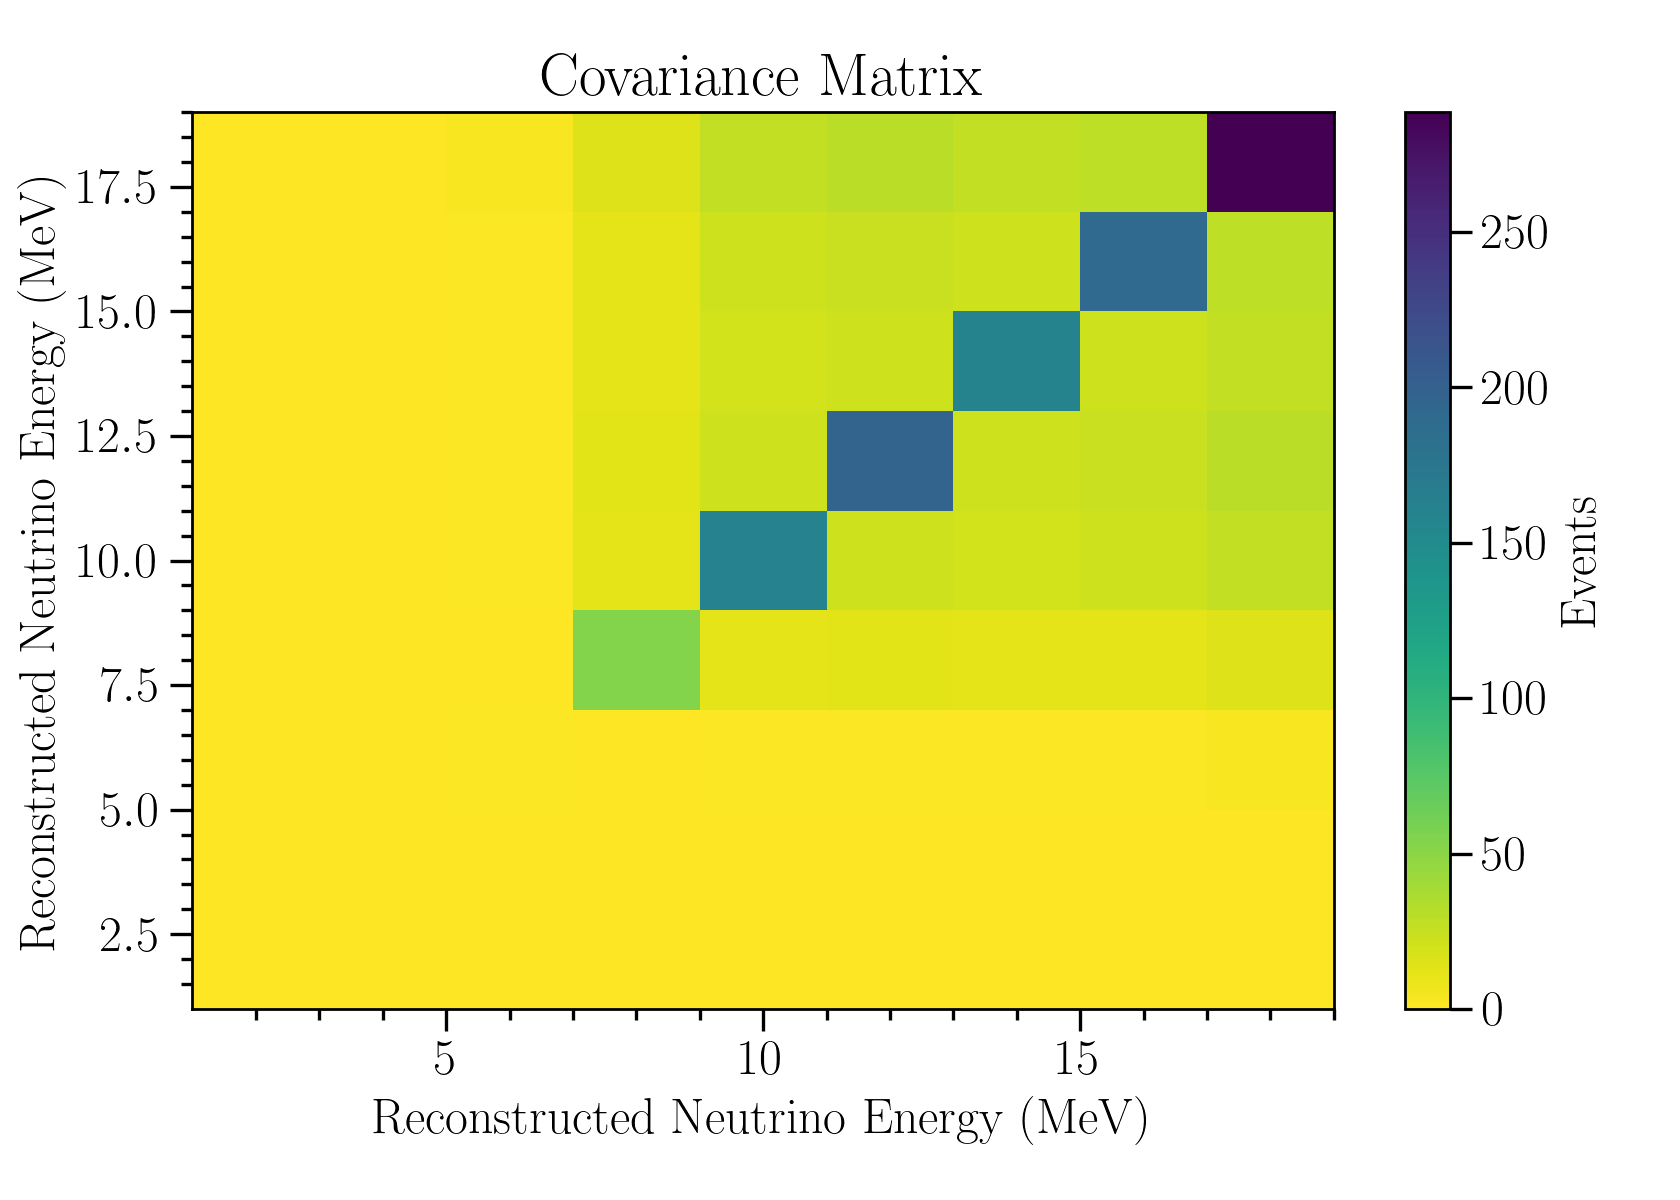

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


In [133]:

# Set up the color scale
cm = plt.get_cmap("viridis_r")
norm = matplotlib.colors.LogNorm(vmin=C.T[C.T > 0].min(), vmax=C.T.max())


X = np.array([reco_energy] * (len(reco_energy)))
Y = np.array([reco_energy] * (len(reco_energy))).T


# Make the plot
fig, ax = plt.subplots(figsize=(8.4, 6))
mesh = ax.pcolormesh( X, Y, C.T, cmap=cm)



# Change the plot style

ax.set_xlabel("Reconstructed Neutrino Energy (MeV)")
ax.set_title("Covariance Matrix")
ax.set_ylabel("Reconstructed Neutrino Energy (MeV)")
cb = fig.colorbar(mesh, ax=ax)
cb.ax.set_ylabel("Events")
cb.ax.minorticks_off()

# Make everything nice
fig.tight_layout()